Let's start with using the open sourced OPENAI CLIP model

In [1]:
import re
import math
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, InterpolationMode
import clip

from PIL import Image
from urllib.request import urlopen

import matplotlib.pyplot as plt
from captum.attr import visualization

device = "cuda" if torch.cuda.is_available() else "cpu"
clipmodel, preprocess = clip.load("ViT-B/16", device=device)

In [2]:
def pre_caption(caption, max_words=50):
    caption = re.sub(
        r"([.!\"()*#:;~])",       
        ' ',
        caption.lower(),
    )
    caption = re.sub(
        r"\s{2,}",
        ' ',
        caption,
    )
    caption = caption.rstrip('\n') 
    caption = caption.strip(' ')

    #truncate caption
    caption_words = caption.split(' ')
    if len(caption_words)>max_words:
        caption = ' '.join(caption_words[:max_words])
            
    return caption

In [3]:
def attention_layer(q, k, v, num_heads=1, attn_mask=None):
    "Compute 'Scaled Dot Product Attention'"
    tgt_len, bsz, embed_dim = q.shape
    head_dim = embed_dim // num_heads
    scaling = float(head_dim) ** -0.5
    q = q * scaling
    
    q = q.contiguous().view(tgt_len, bsz * num_heads, head_dim).transpose(0, 1)
    k = k.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)
    v = v.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)
    attn_output_weights = torch.bmm(q, k.transpose(1, 2))
    if attn_mask is not None:
        attn_output_weights += attn_mask
    attn_output_weights = F.softmax(attn_output_weights, dim=-1)
    attn_output = torch.bmm(attn_output_weights, v)
    assert list(attn_output.size()) == [bsz * num_heads, tgt_len, head_dim]
    attn_output = attn_output.transpose(0, 1).contiguous().view(tgt_len, bsz, embed_dim)
    attn_output_weights = attn_output_weights.view(bsz, num_heads, tgt_len, -1)
    attn_output_weights = attn_output_weights.sum(dim=1) / num_heads
    return attn_output, attn_output_weights
    
def clip_encode_text_dense(text, n):
    x = clipmodel.token_embedding(text).type(clipmodel.dtype)  # [batch_size, n_ctx, d_model]
    attn_mask=clipmodel.build_attention_mask().to(dtype=x.dtype, device=x.device)
    x = x + clipmodel.positional_embedding.type(clipmodel.dtype)
    x = x.permute(1, 0, 2)  # NLD -> LND
    x = torch.nn.Sequential(*clipmodel.transformer.resblocks[:-n])(x)

    #####################
    attns = []
    atten_outs = []
    vs = []
    qs = []
    ks = []
    for TR in clipmodel.transformer.resblocks[-n:]:
        x_in = x
        x = TR.ln_1(x_in)
        linear = torch._C._nn.linear    
        q, k, v = linear(x, TR.attn.in_proj_weight, TR.attn.in_proj_bias).chunk(3, dim=-1)
        attn_output, attn = attention_layer(q, k, v, 1, attn_mask=attn_mask) # num_head=1
        attns.append(attn)
        atten_outs.append(attn_output)
        vs.append(v)
        qs.append(q)
        ks.append(k)
        
        x_after_attn = linear(attn_output, TR.attn.out_proj.weight, TR.attn.out_proj.bias)       
        x = x_after_attn + x_in
        x = x + TR.mlp(TR.ln_2(x))
            
    x = x.permute(1, 0, 2)  # LND -> NLD
    x = clipmodel.ln_final(x).type(clipmodel.dtype)

    # x.shape = [batch_size, n_ctx, transformer.width]
    # take features from the eot embedding (eot_token is the highest number in each sequence)
    x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ clipmodel.text_projection
    return x, (qs, ks, vs), attns, atten_outs

In [4]:
from CLIP.clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
_tokenizer = _Tokenizer()
from clip import tokenize

In [5]:
import cv2
import numpy as np

def sim_qk(q, k):
    q_cls = F.normalize(q[eos_position,0,:], dim=-1) 
    k_patch = F.normalize(k[:,0,:], dim=-1)

    cosine_qk = (q_cls * k_patch).sum(-1)  
    cosine_qk = (cosine_qk-cosine_qk.min()) / (cosine_qk.max()-cosine_qk.min())
    return cosine_qk

def grad_eclip(c, qs, ks, vs, attn_outputs, eos_position):
    ## gradient on last attention output
    tmp_maps = []
    for q, k, v, attn_output in zip(qs, ks, vs, attn_outputs):
        grad = torch.autograd.grad(
            c,
            attn_output,
            retain_graph=True)[0]
        grad_cls = grad[eos_position,0,:]
        # just use the gradient on the cls token position  
        cosine_qk = sim_qk(q, k)
        # print("[cosine_qk]:", cosine_qk.shape) # 77
        tmp_maps.append((grad_cls * v[:,0,:] * cosine_qk[:,None]).sum(-1))

    emap = (F.relu_(torch.stack(tmp_maps, dim=0).sum(0)))
    emap = emap[1:eos_position].flatten()
    emap = emap / emap.sum()
    return emap

def self_attn(attns, eos_position):
    ## attn map of cls token on each word
    # attn: 1,77,77
    
    attn = attns[-1][0, eos_position,:].flatten()
    attn = attn / attn.sum()
    return attn

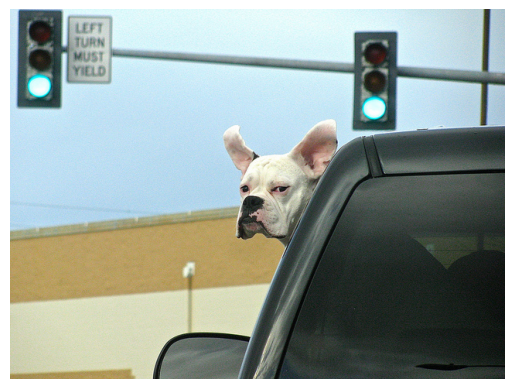

In [6]:
import os
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

img_path = "./dog_and_car.png"
img = Image.open(img_path).convert("RGB")
sentence = "dog in a car waiting for traffic lights."

# url = "http://l7.alamy.com/zooms/1e7674256f464050bf142a5d21407ede/single-cowboy-guiding-a-line-of-horses-through-the-desert-bnh6m3.jpg"
# img = Image.open(urlopen(url))
# sentence = "single cowboy guiding a line of horses through the desert"

plt.imshow(img)
plt.axis('off')
plt.show()

In [7]:
# preprocess image and text
img_preprocessed = preprocess(img).cuda().unsqueeze(0)
img_embedding = clipmodel.encode_image(img_preprocessed)
img_embedding = F.normalize(img_embedding, dim=-1)
print("[image embedding]:", img_embedding.shape)

[image embedding]: torch.Size([1, 512])


In [8]:
# sentence = "dog in a car waiting for traffic lights"
text_processed = clip.tokenize([sentence])

text_tokens=_tokenizer.encode(sentence)
text_tokens_decoded=[_tokenizer.decode([a]) for a in text_tokens]

In [9]:
# grad_eclip
x, (qs, ks, vs), attns, atten_outs = clip_encode_text_dense(text_processed.cuda(), n=8)
text_embedding = F.normalize(x, dim=-1)
print("[text embedding]:", text_embedding.shape)
cosine = (img_embedding @ text_embedding.T)
eos_position = text_processed.argmax(dim=-1)
print("[eos_position]:", eos_position)
print("[cosine]:", cosine)         

[text embedding]: torch.Size([1, 512])
[eos_position]: tensor([10])
[cosine]: tensor([[0.2488]], device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)


In [10]:
grad_emap = grad_eclip(cosine[0], qs, ks, vs, atten_outs, eos_position)
print(grad_emap)

tensor([0.2874, 0.1034, 0.0350, 0.1780, 0.0534, 0.0000, 0.1462, 0.1851, 0.0113],
       device='cuda:0', dtype=torch.float16, grad_fn=<DivBackward0>)


In [11]:
vis_data_records = [visualization.VisualizationDataRecord(grad_emap,0,0,0,0,0,text_tokens_decoded,1)]
visualization.visualize_text(vis_data_records)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,dog in a car waiting for traffic lights .


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,dog in a car waiting for traffic lights .


In [12]:
attn_word = self_attn(attns, eos_position)
vis_data_records = [visualization.VisualizationDataRecord(attn_word,0,0,0,0,0,text_tokens_decoded,1)]
visualization.visualize_text(vis_data_records)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,dog in a car waiting for traffic lights .


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,dog in a car waiting for traffic lights .
